In [3]:
import random
import string
import RNA
import numpy as np
import os
import subprocess
from PIL import Image 
from IPython.display import SVG, display
from collections import deque 
import difflib
import sys

import logging # doesn't print anything, unless a root logger is created
logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)
err = lambda x: logging.error(x)
deb = lambda x: logging.debug(x)
inf = lambda x: logging.info(x)
inf(f'hello!')

sys.path.append(os.path.dirname("/home/mescalin/maxf/pathfinder_project/src"))
import importlib # always reload all .py files / observe changes
import p_tables_helper
import pathfinder
import helper
# import pathfinder_new

importlib.reload(p_tables_helper)
importlib.reload(pathfinder)
importlib.reload(helper)
# importlib.reload(pathfinder_new)

# from helper import generate_structures
# from helper import plot_layout, combine_plots, plot_2_seq


<module 'helper' from '/mnt/c/Users/Max/Google Drive/pathfinder/src/helper.py'>

In [25]:
# 120 nt seq with 1 frozen part
sequence = "GCCGCUAGAUCGAGAUGUUUAGGAUAUGCAAACAGGUCUGGGGGGUCAUGUCUUUAAAGGUCAUCAUGAGGCUCCGCCAAGACUAGAGUCCGGCCGAGCCUACCACGGCUCAUCAUGGCG"
s1 = ".................(((((((((.((...........((((((...))))))...........)).)).).)).))))((((.(((.....))).))))(........)........"
s2 = ".((.((.(((((.(((.(((((((((.((...........((((((...))))))...........)).)).)))...))))..))).)).)))..)).))..................."

# 150 nt seq with 2 frozen parts, 1 non-frozen mid section
sequence = "CGUAAAGUAAGCGCAGGACUAGAGGAAGGCUGGUGCGCGAUAGGCCCCCGAUCAUUGAUCACGUCAAGGACACUCUUGUUGAUGAAGCUAAGGGGCGCCGCCUCCCAUCGCUUUGAAUGACGGCGCAAUGAGGCCCGGAUAUAACUCGGG"
s1 =       "......((...(((.(.(((((.......))))).))))....)).(((((((...))))....(((((....)))))..((.........(((((((((.(...((......))...).)))))).......))).........)))))"
s2 =       "..(.......((((...(((((.......)))))))))(((.((...)).))).(((((...))))).)...((((((((.....))).)))))((((((.(...((......))...).)))))).......(((((.......)))))"

size = 500
# s1_plot = plot_layout(sequence, s1, layout=1, size=size)
# s2_plot = plot_layout(sequence, s2, layout=1, size=size)
# combine_plots([s1_plot, s2_plot], size=size).show()

# s1_plot = helper.plot_layout(sequence, s1, layout=2, size=size)
# s2_plot = helper.plot_layout(sequence, s2, layout=2, size=size)
# helper.combine_plots([s1_plot, s2_plot], size=size)


In [13]:
import RNA
import numpy as np

import subprocess
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import SVG, display
from collections import Counter
from collections import defaultdict

import difflib
import sys
import os
import random
import string
import time

import pathfinder_python
import pathfinder
import pathfinder_cpp
import helper
import merge_composition
import merge_recursive
import merge_dp

import pandas as pd

In [30]:
target_count = 1
min_bp_dist = 10
max_bp_dist = 20
x = 50
s_list = []
Verbose = True

def detect_local_minimum(fc, structure):
    # perform gradient walk from sample to determine direct local minimum
    pt = RNA.IntVector(RNA.ptable(structure))
    fc.path(pt, 0, RNA.PATH_DEFAULT | RNA.PATH_NO_TRANSITION_OUTPUT)
    return RNA.db_from_ptable(list(pt))

while (len(s_list) < target_count):
    
    # RNAsubopt wrapper
    sequence, s1, s2 = helper.generate_structures(x)
    
    print (s1)
    print (s2)
    
    
    # overwrite s1 s2 to local minimum
    fc = RNA.fold_compound(sequence)
    s1 = detect_local_minimum(fc, s1)
    s2 = detect_local_minimum(fc, s2)
    
    print (s1)
    print (s2)
    print ("---")
    
    bp_dist = RNA.bp_distance(s1, s2)
    if bp_dist < min_bp_dist:
        continue
    if bp_dist > max_bp_dist:
        continue
    l = merge_composition.merge_check(sequence, s1, s2, Debug=False)

    # ignore the case where sections provide no benefit
    if len(l) == 1 or l==[0,x]:
        continue            
                

    # for the time being, only consider [x, [i,j], y]
    # if len(l[1]) > 2 or len(l)>3:
    #     continue
    
    search_width=10


    init_verbose = False
    # init_results = pathfinder.pathfinder(sequence, s1, s2, search_width=500, verbose=init_verbose)
    # init_results2 = pathfinder.pathfinder(sequence, s2, s1, search_width=500, verbose=init_verbose)
    # init_results = pathfinder.pathfinder(sequence, s1, s2, search_width=search_width, verbose=False)
    # init_results2 = pathfinder.pathfinder(sequence, s2, s1, search_width=search_width, verbose=False)
    # if round(init_results.max_en,2) != round(init_results2.max_en,2):
    #     print (init_results, init_results2)
    #     print (sequence)
    #     print (s1)
    #     print (s2)
    #     break

    init_results = pathfinder.pathfinder(sequence, s1, s2, search_width=search_width, verbose=init_verbose)

    sections = merge_composition.merge_check(sequence, s1, s2)    
    search_width=search_width*2
    merge_results = merge_recursive.recursive_merge(sequence, s1, s2, sections, search_width=search_width, Verbose=Verbose, Debug=False, plot_graph=False, new=False)
    init_results = round(init_results.max_en, 2)
    merge_results = round(merge_results.max_en, 2)
    print ("init:", init_results, "with dp", merge_results)
    
    
    s_list.append((sequence, s1, s2, l))

(((....)))..((..((.....))))....((((........))))...
.(((((......(((.(((........))))))......))).)).....
(((....)))..((..((.....))))...(((((........)))))..
((((((......(((.(((........))))))......))).)))....
---
...................(((..((((.....))))....)))......
.................(.(((..((((.....))))....))).)....
...................(((..((((.....))))....)))......
...................(((..((((.....))))....)))......
---
....((((((.................................)))))).
....((((((.................................)))))).
....((((((.................................)))))).
....((((((.................................)))))).
---
(((.((((........)).)))))(((((((((...)))).)))))....
.(.(((((........)).)))).(((((((((...)))).)))))....
(((.((((........)).)))))(((((((((...)))).)))))....
((.(((((........)).)))))(((((((((...)))).)))))....
---
.................(((((((((((......)))....)))))))).
.................((((((((.((..........)).)))))))).
.................(((((((((((......)))....)))))))).
...............

In [23]:
# [0, [28, 41], 50]
# UCGGACAGAAACGGUUGAGGGGCGGCGGGAAGCGAUUGUUCUAGGCGCGG
# ((.(((.......)))..)).(((.(.((((.......)))).).)))..
# (((........))).......(((.(.((.(((....))))).).)))..
# start findpath outer section [0, 50]
# Base-pair distance: 8
# ((.(((.......)))..)).(((.(.(.............).).)))..  -1.00 []
# .(.(((.......)))..)..(((.(.(.............).).)))..  -0.70 [-1, -20]
# ...(((.......))).....(((.(.(.............).).)))..  -1.40 [-2, -19]
# ....((.......))......(((.(.(.............).).)))..   0.00 [-4, -16]
# .....(.......).......(((.(.(.............).).)))..   1.30 [-5, -15]
# .....................(((.(.(.............).).)))..  -2.20 [-6, -14]
# ..(........).........(((.(.(.............).).)))..  -0.70 [3, 12]
# .((........))........(((.(.(.............).).)))..  -3.10 [2, 13]
# (((........))).......(((.(.(.............).).)))..  -3.20 [1, 14]
# S:   1.30 kcal/mol | B:   2.30 kcal/mol | E[0]: -1.00 E[9]: -3.20 | min E1:  -0.40 / min E2:   0.00  | 0.00 s
# Start inner section [28, 41]
# Base-pair distance: 5
# ............................(((.......))).........   0.60 []
# ............................(((.(....)))).........   1.40 [33, 38]
# ............................((..(....).)).........   3.70 [-31, -39]
# ............................((.((....)))).........   1.40 [32, 39]
# ............................(..((....)).).........   3.60 [-30, -40]
# ............................(.(((....)))).........   1.40 [31, 40]
# S:   3.70 kcal/mol | B:   3.10 kcal/mol | E[0]:  0.60 E[6]:  1.40 | min E1:   0.00 / min E2:   0.00  | 0.00 s
# Best merged path: 3
# ((.(((.......)))..)).(((.(.((((.......)))).).)))..  -7.80 [   0,    0]
# .(.(((.......)))..)..(((.(.((((.......)))).).)))..  -7.50 [  -1,  -20]
# ...(((.......))).....(((.(.((((.......)))).).)))..  -8.20 [  -2,  -19]
# ....((.......))......(((.(.((((.......)))).).)))..  -6.80 [  -4,  -16]
# .....(.......).......(((.(.((((.......)))).).)))..  -5.50 [  -5,  -15]
# .....................(((.(.((((.......)))).).)))..  -9.00 [  -6,  -14]
# ..(........).........(((.(.((((.......)))).).)))..  -7.50 [   3,   12]
# .((........))........(((.(.((((.......)))).).)))..  -9.90 [   2,   13]
# (((........))).......(((.(.((((.......)))).).))).. -10.00 [   1,   14]
# (((........))).......(((.(.((((.(....))))).).)))..  -9.20 [  33,   38]
# (((........))).......(((.(.(((..(....).))).).)))..  -6.90 [ -31,  -39]
# (((........))).......(((.(.(((.((....))))).).)))..  -9.20 [  32,   39]
# (((........))).......(((.(.((..((....)).)).).)))..  -7.00 [ -30,  -40]
# (((........))).......(((.(.((.(((....))))).).)))..  -9.20 [  31,   40]
# S:  -5.50 kcal/mol | B:    inf kcal/mol
# init: -5.5 with dp -5.5


# s_list

# [0, [24, 44], 60]
# CGUCUGUUGGACGUAUAAGAAGGGAGGCUGAACGUAAGUUAACUCGCGAGUGUGUACGUU
# .((((...))))(((((....(.(((....(((....)))..))).).....)))))...
# .........((((((((....(.((((((.......)))...))).).....))))))))
# start findpath outer section [0, 60]
# Base-pair distance: 7
# .((((...))))(((((....(.(....................).).....)))))...  -4.30 []
# ..(((...))).(((((....(.(....................).).....)))))...  -0.70 [-2, -12]
# ..(((...)))((((((....(.(....................).).....))))))..  -2.70 [12, 58]
# ...((...)).((((((....(.(....................).).....))))))..  -1.70 [-3, -11]
# ...((...))(((((((....(.(....................).).....))))))).  -3.00 [11, 59]
# ...(.....)(((((((....(.(....................).).....))))))).  -2.10 [-5, -9]
# ..........(((((((....(.(....................).).....))))))).  -5.30 [-4, -10]
# .........((((((((....(.(....................).).....))))))))  -6.30 [10, 60]
# S:  -0.70 kcal/mol | B:   3.60 kcal/mol | E[0]: -4.30 E[8]: -6.30 | min E1:   0.00 / min E2:  -0.00  | 0.00 s
# Start inner section [24, 44]
# Base-pair distance: 6
# ........................((....(((....)))..))................   0.00 []
# ........................((.....((....))...))................   2.00 [-31, -40]
# ........................((......(....)....))................   3.70 [-32, -39]
# ........................((................))................   2.20 [-33, -38]
# ........................((..(.......).....))................   5.80 [29, 37]
# ........................((.((.......))....))................   3.90 [28, 38]
# ........................(((((.......)))...))................   1.30 [27, 39]
# S:   5.80 kcal/mol | B:   5.80 kcal/mol | E[0]:  0.00 E[7]:  1.30 | min E1:   0.00 / min E2:   0.00  | 0.00 s
# Best merged path: 3
# .((((...))))(((((....(.(((....(((....)))..))).).....)))))... -12.20 [   0,    0]
# ..(((...))).(((((....(.(((....(((....)))..))).).....)))))...  -8.60 [  -2,  -12]
# ..(((...)))((((((....(.(((....(((....)))..))).).....)))))).. -10.60 [  12,   58]
# ...((...)).((((((....(.(((....(((....)))..))).).....))))))..  -9.60 [  -3,  -11]
# ...((...))(((((((....(.(((....(((....)))..))).).....))))))). -10.90 [  11,   59]
# ...(.....)(((((((....(.(((....(((....)))..))).).....))))))). -10.00 [  -5,   -9]
# ..........(((((((....(.(((....(((....)))..))).).....))))))). -13.20 [  -4,  -10]
# .........((((((((....(.(((....(((....)))..))).).....)))))))) -14.20 [  10,   60]
# .........((((((((....(.(((.....((....))...))).).....)))))))) -12.20 [ -31,  -40]
# .........((((((((....(.(((......(....)....))).).....)))))))) -10.50 [ -32,  -39]
# .........((((((((....(.(((................))).).....)))))))) -12.00 [ -33,  -38]
# .........((((((((....(.(((..(.......).....))).).....))))))))  -8.40 [  29,   37]
# .........((((((((....(.(((.((.......))....))).).....)))))))) -10.30 [  28,   38]
# .........((((((((....(.((((((.......)))...))).).....)))))))) -12.90 [  27,   39]
# S:  -8.40 kcal/mol | B:    inf kcal/mol
# init: -8.4 with dp -8.4

In [12]:

sequence, s1, s2 = helper.generate_structures(150)
helper.save_seq(sequence, s1, s2, "../sample_seqs/last_generated.seq")

# GGGUUGUCUCUCGGCCGGCCCUCAACAACCUGUUGGCUGCGUCUCUCUCGUGCUGGCUAUCUUCUAUGCUCAUACUAAUACUCUAUGCCA
# ((((((((....)).))))))((((((...))))))..................(((.......(((..........)))......))).
# ((((((((....)).)))))).(((((...)))))...((((.......(((.((((..........)).))))).........))))..
# sequence = "GGAGCCCCGAAAGGCGGCUCCAUGGAGCUUUGCUCCGGUCCUAAAAAAAAUCUCAACCGUUAAAAUGUGGCUUAGAAAACAGAAAUAGGUG"
# s1 =       "((((((((....)).)))))).((((((...))))))..................(((.......(((..........)))......)))."
# s2 =       "((((((((....)).))))))..(((((...)))))...((((.......(((.((((..........)).))))).........)))).."
# sequence = "CCCAGUCCCUUCGGCGUUGGGAUGUAGGAUACCUACACAGCUUUAAAAAAUCGACGGCAGAAAUAAUGGUACGCGAAACAUACACAGGCCU"
# s1 =       "((((((((....)).)))))).((((((...))))))..................(((.......(((..........)))......)))."
# s2 =       "((((..(((...)).)).)))..(((((...)))))...((((.......(((.((((..........)).))))).........)))).."
# helper.save_seq(sequence, s1, s2, "../sample_seqs/blueprint_96.seq")

print(f'sequence = "{sequence}"\ns1 =       "{s1}"\ns2 =       "{s2}"')


# split_numbers, splits = p_tables_helper.split(sequence, s1, s2)
# print("splits:", split_numbers)
# print ("splits:", p_tables_helper.common(sequence, s1, s2))

# p_tables_helper.common(sequence, s1, s2)


path = pathfinder.pathfinder(sequence, s1, s2, verbose=False)
sE = path.max_en; 

# moves_str = path.moves_en; moves_pos = path.moves_pos; moves_str = path.moves_str


print ('bp distance: ', RNA.bp_distance(s1, s2))
# print (sE, e1, e2)

# print (pathfinder_new.find_path(sequence, s1, s2))

size = 60
logger.propagate = False
s1_plot = helper.plot_layout(sequence, s1, layout=2, size=size)
s2_plot = helper.plot_layout(sequence, s2, layout=2, size=size)
helper.combine_plots([s1_plot, s2_plot], size=size)


sequence = "UAGCGCUUAGAUUAUUUAUCGCUGCCUGGCGGCGAAACUUAGGCGGGUCAGUCGCCGUACGAACACACGAGAGACCAUCCCUCAUUAGGGUUUCGAUGUUGACAGGUCCAAGAAUAUCUCAAACGUAAAAGUGAGUACCAUCCGAUAGUC"
s1 =       "...(((((((.((.....(((((((...))))))))).))))))).....((((..((((..((...(((((......(((......))))))))(((((...(((..........)))..)))))....))..))))....))))...."
s2 =       ".........((((((...(((((((...)))))))......((..((((..(((..((......)).)))..))))..))((((((.(.((((.((((((............))))))..)))).)...)))))).........))))))"
bp distance:  69


FileNotFoundError: [Errno 2] No such file or directory: 'gs'

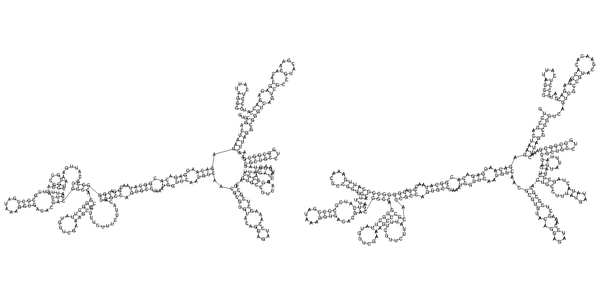

In [23]:
s1_plot = helper.plot_layout(sequence, s1, layout=1, size=size)
s2_plot = helper.plot_layout(sequence, s2, layout=1, size=size)
helper.combine_plots([s1_plot, s2_plot], size=size)

91
S: -19.20 kcal/mol | B:   7.10 kcal/mol | E[0]:-26.30 E[19]:-24.40 | 0.01 s


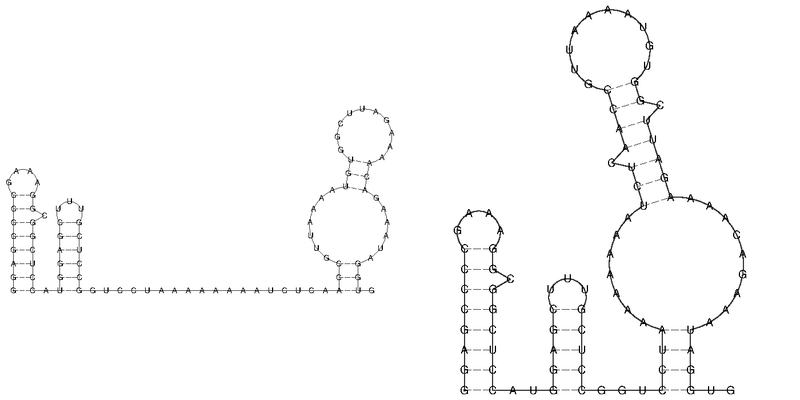

In [9]:
# sequence = "GCACAAAGGCACGAUAGCGCAGGCAAAGCCAAUCAAUCAGCGGAGAGUGAAACCCGGCCCCAAGGACCCCAGCUGUGACCGUUUAAAUCGGAAGCACUCAUC"
# s1 =       "((.(...)))..(((((.((.(((...)))..((...((((((.(.(.(...)))((.((...)).)))).)))).))(((.(...).)))..)).)).)))"
# s2 =       "((.(...)))..((..(.((.(((...)))..((...((((((.(.(..........((....)).)))).)))).))(((.(...).)))..)).)))..."
# s1 =       "............(((((.((.(((...)))..((...((((((.(.(.(...)))((.((...)).)))).)))).))...............)).)).)))"
# s2 =       "............((..(.((.(((...)))..((...((((((.(.(..........((....)).)))).)))).))...............)).)))..."
# s1 =       "............(((((.((.................((((((.(.(.(...)))((.((...)).)))).))))..................)).)).)))"
# s2 =       "............((..(.((.................((((((.(.(..........((....)).)))).))))..................)).)))..."
# s1 =       "............(((((.((......................(.(.(.(...)))((.((...)).)))........................)).)).)))"
# s2 =       "............((..(.((......................(.(.(..........((....)).)))........................)).)))..."
# helper.save_seq(sequence, s1, s2, "./samples/blueprint_102.seq")

# s1 =       "(.((((((...........)))))).)........((.((((..((((...(((...)))........))))..))))))..(((.(...).)))."
# s2 =       "((((((((...((....))))))))...))........((((..(((((..(((...))).)......))))..))))....(((.(...).)))."
# sequence = "GUUCUGGGGAACCUACCGGCCCAGAUCUACAAAAAACAGGAGUUUCACCAAGCCAAAGGCCGACAAAAGUGAUUCUCCGUAAGGGCGCAUCUCCCA"
# s1 =       "...................................((.((((..((((...(((...)))........))))..))))))..(((.(...).)))."
# s2 =       "......................................((((..(((((..(((...))).)......))))..))))....(((.(...).)))."
# sequence = "GUAGGAUUAAACGUAACCGGAUCCUUCAACGAAAACACUGCCGAAAUGUAAGCGAAACGCGAAAAAAGUAUUGGGGCAUGAAAGCGCACUGGGCUA"
# s1 =       "(.((((((...........)))))).)....................................................................."
# s2 =       "((((((.....((....))..))))...)).................................................................."
# sequence = "GUAGGAUUAAACGUAACCGGAUCCUUCAACGAAAACACUGCCGAAAUGUAAGCGAAACGCGAAAAAAGUAUUGGGGCAUGAAAGCGCACUGGGCUA"


print (len(sequence))

path = pathfinder.pathfinder(sequence, s1, s2, verbose=False, output="../folding_paths/blueprint_101.out")
sE = path.sE; barrier = path.barrier; e1 = path.e1; e2 = path.e2;    
moves_str = path.moves_en; moves_pos = path.moves_pos; moves_str = path.moves_str
size = 400
s1_plot = helper.plot_layout(sequence, s1, layout=3, size=size)
s2_plot = helper.plot_layout(sequence, s2, layout=3, size=size)
helper.combine_plots([s1_plot, s2_plot], size=size)


In [75]:
# plot_2_seq(sequence, s1, s2, layout=1)

# 300
sequence = "ACGAAGUGGAUGACCAGGGAUGAAACCACGCUGGGCCAGCUUCCUCCCUCCGAUGUGUGCUCAUUCCAUAAGAUCCAGGCGGUGCGCCUCAAUCACUCACCUGUUUAGAUCCUUUUAUCCAUGGGGGACAUUGCCGGAGCUGAUCUGUAAUUUAUUCAGCGAUCCCCUGAGAUCCUGGCUCUUCCGUUCGGCUCUAGUCGCUAUAUAAUCCCAGCGUAUUAGUUAUGGCCUGGAGGUAGAAGCGUUAGAGCAAUACUUCUACAGAGACCACGUGAGGUAGCUGUCUUAAGUCGUUGCUUA"
s1 = ".((((.((((.((((((((((((.((((((..(((..........)))..)).)).))..)))))))......(((.(((((((..(((((..........((..((((....))))..)))))))..))))))))))(((((............)))))((((......)))).))).)).))))))))..(((((.((((...((...((((((((.....))))..))))...))..)))))))))(((((((((..((((..(((......)))..))))...)))).)))))..."
s2 = ".((((.((((.((((((((((((...((((((.((..((........)))).).))))).)))).))..........(((((((..(((((...((......))..(((....))).....)))))..)))))))...(((((............)))))((((......)))))))).)).))))))))((((((..((((.(...(((((((((((.....))))..)))).)))..))))).)))))).........((((..(((......)))..))))...((((....))))."

sequence = "UCGAUUCCCGGGGCAGUAGUGUCCUACUGCCCAACCCGGUAGAGGGAUCGAGUGGUCUAGGCGAAUGAUACGAGAGGCUCACUGGGGACGAUGGGAGUGAUCUACUCGAUGUUGCGUCCGAUCACAUCCAAGCUUAAUGAUCCACGGGUUCGCUGCACUGCAGCUUUUCACGGACUCUGUGCCGUUUGGAGUGACCAGGUCUCUCCCGCUUCGCGCGAGGUGGGUCCACGCAAGCCGGCACGCGAAAGGGCGGCUAUGUACAGCUCUUAAAACCACCAGAGGUUUAGUGAUCACUGAGGC"
s1 = "(((((((((((((((((((....)))))))))....)).....))))))))(((((..((((.........((((((((...((((((((....(((((...))))).......)))))..((((.(((((((...(((.(((...((...(((((...)))))...))..)))...)))...))))))))))))))))))))))(((((((....)))))))......((((((((.(.(......)).))))).)))...)).))....)))))....(.((((((....)))))).)"
s2 = "(((((((((((((((((((....)))))))))....)).....))))))))(((((.((((.(..((.((((((((((...(((((((((((..(((((...)))))...))..)))))..((((.((((.....((((...(((.((((((((((...))))).......)))))..))).)))))))))))))))))))))))(((((((....))))))).........(((((.(.(......)).)))))..))))).).))))..)))))....(.((((((....)))))).)"

# hard
sequence = "UCCACGUGUAAGAAACCCGGAAACAUCGUUUGGCUUAGAAUGAACAGAUAGAUUGCCUACAACAAAAUACUGAUGACGGGGGAGCCGUGACAUGGCGGCCACCGCUAGUCGGCCUACGCUUUAAAACAUAUGCUGUUAUCAGACGCCAGUCCAUCUUCGGUCACGAGCGCCUGGUACCUUCUUAAGAAGUAGCGCUGGUGGAUAAUGUUUCUCAUGCCGGCAAGGCCUCCACGUCUCCGGUCUUUGACGAGUCUCAUUCAAUGGCUGGUAGGCUGAUAGCAGCCUUACAUUCUCAGGCAA"
s1 = "...((((((..(.....)....))).))).((.((.((((((..(((.((..(((.......)))..)))))...((((.....))))(((.((((((...)))))))))(((....)))...........(((((((((((.((((((.((((......((((.(((((....(((.(((....))))))))))).))))...(((.....)))(((((.(.(((......))))))))).......((((...)))).))))))))).).)))))))))))....)))))).)).).)"
s2 = ".....(((((((...((((..(...((((((......)))))).(((.((..(((....))).....))))).)..))))((.((((.....((((((...))))))..))))))................(((((((((((.((((((.((((......((((.(((((.((....((((....))))))))))).))))..(((((((.(((.(((((..(.(......).)..)))))...))).)))...))))..)))))))))..))))))))))))))))))).........."

sequence = "ACUGGCGAUAAUUAUUUGCAUGAUGGAUCCAAUCCAAUGCAGUCGAGUGAAGUACCGUCGUAGUAGCUAUAACCACCUUAUUCUUGCCCCCUGCAAGCGCUAGAUACUGAUCCAUGCUAAUAAAGUAGUCAUACGUCAAGCGAGACAUUGUUACGUGAUGGAUAAUGGUAUGCAUACACCUGGGCUGCACUCUAGCAGCAUACUCUUUGUUAUACAGCGCGUUUAUACUAGUUGGGGUAGGGGCCCGACUAAUAGCAGUUCUUUGACAAUUCUUCUGCGUUAUUCAUUUUGAUAACAAUU"
s1 = ".((((((.(..(((((((..((.(((((...)))))...))..)))))))...).))))((((...))))............(((((.....)))))((((.(((..((((...((((.....))))))))...))).))))))..(((((((((.(((((((((((((........)))...(((((......)))))........((((.....((((.....((.((((((((.(...).)))))))).)))).)).....))))..........)))))))))).)).)))))))."
s2 = ".((((((........((((((..((((.....))))))))))..((((((.((...((.((((...)))).)).)).))))))((((.....)))).))))))....((((..((((((......))).)))..))))........(((((((((.(((((((((((.....(.........)(((((......))))).......((((((...((.(((.((((..((((((((.(...).))))))))))))).)).)).))))))........))))))))))).)).)))))))."

split_numbers, splits = p_tables_helper.split(sequence, s1, s2)

print(split_numbers)

for sequence, s1, s2 in splits:
    if len(sequence)==1:
        continue
    print(sequence, s1, s2)
    # refold_func(sequence, s1, s2, verbose=True)
    refold_func(sequence, s1, s2, output="refold_split.txt")
    # time_refold_func(sequence, s1, s2)

[(0, 143), (144, 144), (145, 145), (146, 298), (299, 299)]
ACUGGCGAUAAUUAUUUGCAUGAUGGAUCCAAUCCAAUGCAGUCGAGUGAAGUACCGUCGUAGUAGCUAUAACCACCUUAUUCUUGCCCCCUGCAAGCGCUAGAUACUGAUCCAUGCUAAUAAAGUAGUCAUACGUCAAGCGAG .((((((.(..(((((((..((.(((((...)))))...))..)))))))...).))))((((...))))............(((((.....)))))((((.(((..((((...((((.....))))))))...))).)))))) .((((((........((((((..((((.....))))))))))..((((((.((...((.((((...)))).)).)).))))))((((.....)))).))))))....((((..((((((......))).)))..))))......
Saddle: -15.00 kcal/mol | Barrier:   7.70  13.00 kcal/mol | e1:-22.70 e2:-28.00
AUUGUUACGUGAUGGAUAAUGGUAUGCAUACACCUGGGCUGCACUCUAGCAGCAUACUCUUUGUUAUACAGCGCGUUUAUACUAGUUGGGGUAGGGGCCCGACUAAUAGCAGUUCUUUGACAAUUCUUCUGCGUUAUUCAUUUUGAUAACAAU (((((((((.(((((((((((((........)))...(((((......)))))........((((.....((((.....((.((((((((.(...).)))))))).)))).)).....))))..........)))))))))).)).))))))) (((((((((.(((((((((((.....(.........)(((((......))))).......((((((...((.(((.((((..((((((((.(...).))))))))))))).)).)).)

AUGAACAGAUGGUACCUCGCGGCGGGGCCUGACCCAUCUACAGUUUGUGCAGCUUGACNNNGCAUCCCUGGUCAAUUCCCGGAGAAGAUUGGACCAGACGAUG
((((((((((((..(((((...)))))......))))))...)))))).........(...)((((.((((((..................))))))..))))
.((..((((..(((((....))..(((.....)))...)))..))))..))................((((((...((........))...))))))......
Base-pair distance: 38
 0 ((((((((((((..(((((...)))))......))))))...)))))).........(...)((((.((((((..................))))))..)))) -17.80 []
 1 ((((((((((((..(((((...)))))......))))))...))))))..............((((.((((((..................))))))..)))) -22.10 [-57, -61]
 2 ((((((((((((..(((((...)))))......))))))...))))))..............((((.((((((....(........)....))))))..)))) -21.80 [77, 86]
 3 ((((((((((((..(((((...)))))......))))))...))))))..............((((.((((((...((........))...))))))..)))) -24.40 [76, 87]
 4 ((((((((((((..((((.....))))......))))))...))))))..............((((.((((((...((........))...))))))..)))) -23.20 [-18, -22]
 5 ((((((((((((..(((.......)))......))))))...)))))).

In [25]:
print()

In [5]:
# which part has the largest contribution?

barriers = []
for i, r in enumerate(results):
    # print (r.barrier, r.s_pos)
    barriers.append((r.barrier,i,r.s_pos))

barriers.sort(reverse=True) # max first
barriers

part_A = barriers[0]
part_B = barriers[1]

In [6]:
# # which part has the largest contribution?

# barriers = []
# for i, r in enumerate(results):
#     # print (r.barrier, r.s_pos)
#     barriers.append((r.barrier,i,r.s_pos))

# barriers.sort(reverse=True) # max first

# lower_paths = []
# upper_paths = []

# for barrier, i, barrier_pos in barriers:

#     lower = (0,barrier_pos)
#     upper = (barrier_pos,len(results[i].moves_str))

#     lower_paths.append(results[i].moves_str[lower[0]:lower[1]])
#     upper_paths.append(results[i].moves_str[upper[0]:upper[1]])
#     # print (results[i].moves_str[upper[0]:upper[1]])

#     # print (barrier, i, barrier_pos, upper, lower)

# print (lower_paths)

# candidates = [lower_paths[0][0], lower_paths[1][0]]
# # if len(lower_paths[0]) > 1:
# candidates

In [7]:
# find starting point - min/max
fc = RNA.fold_compound(sequence)
# i = 0
# j = 0

print (part_A, part_B)

part_A_energy, part_A_i, part_A_argmin = part_A
part_B_i = 1-part_A_i

saddle_E = float("inf")
part_B_argmax = None

for i in range(len(results[part_B_i].moves_str)):
    c_str = ['.'] * len(s1)

    # print (results[0].moves_str[part_A_argmin])
    # print (results[1].moves_str[part_A_argmin])

    c_str[split_numbers[part_A_i][0]:split_numbers[part_A_i][1]] = results[part_A_i].moves_str[part_A_argmin]
    c_str[split_numbers[part_B_i][0]:split_numbers[part_B_i][1]] = results[part_B_i].moves_str[i]        
    c_str = "".join(c_str)
    eval =  fc.eval_structure(c_str)

    if eval < saddle_E:
        saddle_E = eval
        part_B_argmax = i
    print (f"{c_str}, {eval:6.2f}")
    # break

saddle_E, part_B_argmax

c_str = ['.'] * len(s1)
c_str[split_numbers[part_A_i][0]:split_numbers[part_A_i][1]] = results[part_A_i].moves_str[part_A_argmin]
c_str[split_numbers[part_B_i][0]:split_numbers[part_B_i][1]] = results[part_B_i].moves_str[part_B_argmax]
c_str = "".join(c_str)
eval =  fc.eval_structure(c_str)
eval, c_str

(8.0, 1, 5) (2.2, 0, 5)
((((((((....)).)))))).((.(.((...)))))............................(..............)..........,  -1.10
((((((((....)).)))))).((...((...)).))............................(..............)..........,  -1.80
((((((((....)).)))))).((...(.....).))............................(..............)..........,  -1.40
((((((((....)).)))))).((...........))............................(..............)..........,  -2.40
((((((((....)).)))))).(((........).))............................(..............)..........,  -4.10
((((((((....)).)))))).(((.(...)..).))............................(..............)..........,  -0.60
((((((((....)).)))))).(((((...)).).))............................(..............)..........,  -2.80


(-4.099999904632568,
 '((((((((....)).)))))).(((........).))............................(..............)..........')

In [18]:
positions = [None, None]
positions[part_A_i] = part_A_argmin
positions[part_B_i] = part_B_argmax

# repeat
c_str = ['.'] * len(s1)
c_str[split_numbers[part_A_i][0]:split_numbers[part_A_i][1]] = results[part_A_i].moves_str[part_A_argmin]
c_str[split_numbers[part_B_i][0]:split_numbers[part_B_i][1]] = results[part_B_i].moves_str[part_B_argmax]
c_str = "".join(c_str)
eval =  fc.eval_structure(c_str)
eval, c_str
print (c_str, eval, "start")
print()

# start greedy in one direction
while (positions != [0,0]):

    # print (positions)

    i = positions[part_A_i]
    j = positions[part_B_i]

    candidates = []

    a_str = ['.'] * len(s1)
    a_str[split_numbers[part_A_i][0]:split_numbers[part_A_i][1]] = results[part_A_i].moves_str[i]
    a_str[split_numbers[part_B_i][0]:split_numbers[part_B_i][1]] = results[part_B_i].moves_str[j-1]
    a_str = "".join(a_str)
    candidate_a = fc.eval_structure(a_str)
    # print (c_str, eval)

    b_str = ['.'] * len(s1)
    b_str[split_numbers[part_A_i][0]:split_numbers[part_A_i][1]] = results[part_A_i].moves_str[i-1]
    b_str[split_numbers[part_B_i][0]:split_numbers[part_B_i][1]] = results[part_B_i].moves_str[j]
    b_str = "".join(b_str)
    candidate_b = fc.eval_structure(b_str)
    # print (c_str, eval)

    if (i==0):
        print (b_str, candidate_b, "take")
        positions[part_B_i] -= 1
        continue
    if (j==0):
        print (a_str, candidate_a, "take")
        positions[part_A_i] -= 1
        continue

    if (candidate_a > candidate_b):
        # print (a_str, candidate_a)
        print (b_str, candidate_b, "<", candidate_a)
        positions[part_A_i] -= 1
    else:
        # print (b_str, candidate_b)
        print (a_str, candidate_a, "<", candidate_b)
        positions[part_B_i] -= 1        

    # break

((((((((....)).)))))).(((........).))............................(..............).......... -4.099999904632568 start

((((((((....)).)))))).(((........).))............................((............)).......... -5.300000190734863 < -2.4000000953674316
((((((((....)).)))))).(((........).))............................(((..........))).......... -8.0 < -3.5999999046325684
((((((((....)).)))))).((...........))............................(((..........))).......... -6.300000190734863 < -5.699999809265137
((((((((....)).)))))).((...(.....).))............................(((..........))).......... -5.300000190734863 < -4.0
((((((((....)).)))))).((...((...)).))............................(((..........))).......... -5.699999809265137 < -3.0
((((((((....)).)))))).((.(.((...)))))............................(((..........))).......... -5.0 < -3.4000000953674316
((((((((....)).)))))).(((((...)).).))............................(((..........))).......... -6.699999809265137 take
((((((((....)).)))))).(((((

In [3]:
# generate X random sequences ~ x nt

s_list = []
x = 170

while (len(s_list) < 2 ):
    sequence, s1, s2 = helper.generate_structures(x)
    split_numbers, splits = p_tables_helper.split(sequence, s1, s2)
    # print (split_numbers, split_numbers[0][1]-split_numbers[0][0])
    if len(split_numbers) == 2 and split_numbers[0][1]-split_numbers[0][0] > 20 and s1!=s2: 
        
        # consider ... 
        if s1[split_numbers[0][1]] == '.' and s1[split_numbers[1][0]] == '.' and\
           s2[split_numbers[0][1]] == '.' and s2[split_numbers[1][0]] == '.':
    
            s_list.append((sequence, s1, s2))

s_list

[(&#39;GCCACUGUGCGAUUGAUGUGAUCGACGAUACGACAAAAUUAGGGAUGGAAAGUAACAGUUGGACCCAGUAACAUCCAACGCAAUAGGGGAGGGCUCCGUGGACGUGGCCCAUGUAGUUUAGACGAGCCUCGCAUCGUGCCUAUGAUCUAUCUCAUUUGAUAAUGCAACAC&#39;,
  &#39;.........(((((.....))))).................((((((((........((((((..........))))))(((....(.((.((((((((((.......)))))..........))))))).)....)))......))))))))..(((......)))...&#39;,
  &#39;......(((((.(((((...))))))).)))..........((((((((..(((...((((((..........))))))((.....(.((((.(((..(((((...((....)).)))))...))))))).).....)).)))..)))))))).................&#39;),
 (&#39;AUCCCGAUGAUAUAACACUUCCGCUCUUAAAUUAAGAGCGUGUUUCGCGGAACAUCUAGCUCUUCUCGUGACCUAGUCAUCUGGGCGGCAUUUCCGAGGCGUUUCAGAUGAAGCUUACAAAGAAUGCUCGCAAUGGGUCUCCUUCCUGUGUGAGAACUAAGUGAGGCAAU&#39;,
  &#39;..............((((....(((((.......))))))))).((((((((..........))).))))).....(((((((((((.(........).)).)))))))))..(((((..((....((((((..(((......)))..))))))..))..))))).....&#39;,
  &#39;.((((((......((((....((((((((...))))))))))))))).))).((((((((...(((((...(

In [10]:
# try - explore the whole space

Verbose = True

for s, (sequence, s1, s2) in enumerate(s_list):
    # if s<2:
    #     continue
    # if s>2:
    #     break

    fc = RNA.fold_compound(sequence)

    path = pathfinder.pathfinder(sequence, s1, s2, verbose=Verbose)
    sE = path.sE; barrier = path.barrier; e1 = path.e1; e2 = path.e2;    
    moves_str = path.moves_en; moves_pos = path.moves_pos; moves_str = path.moves_str

    split_numbers, splits = p_tables_helper.split(sequence, s1, s2)

    print ("i =", s, "orig:", sE)
    print(f'sequence = "{sequence}"\ns1 =       "{s1}"\ns2 =       "{s2}"')

    # split up into 2 pieces
    results = []

    for split_0, split_1 in split_numbers:
        c_sequence = sequence[split_0:split_1+1]
        c_s1 = s1[split_0:split_1+1]
        c_s2 = s2[split_0:split_1+1]
        # print(f'sequence = "{c_sequence}"\ns1 =       "{c_s1}"\ns2 =       "{c_s2}"')    
        results.append(pathfinder.pathfinder(c_sequence, c_s1, c_s2, verbose=Verbose))

    st_list = [[],[]]
    for i, res in enumerate(results):
        for entry in res.moves_str:
            st_list[i].append(entry)
        # print (res.barrier, res.sE)

    # can we join the 2 solutions to get the original solution??

    # recursive exhaustive walk
    def r_merge(st_list, moves=[(st_list[0][0], st_list[1][0])]):
        # print (len(st_list[0]), moves)
        if len(st_list[0]) == 1 and len(st_list[1]) == 1:
            # print('done', moves)
            yield moves
        # take a move either from the left or right side
        if len(st_list[0]) > 1:
            left = [st_list[0][1:], st_list[1][:]]
            # print (st_list[0][1], st_list[1][0])
            moves_l = moves.copy()
            moves_l.append((st_list[0][1], st_list[1][0]))
            # r_merge(left, moves=moves_l)
            yield from r_merge(left, moves=moves_l)
        if len(st_list[1]) > 1:
            right = [st_list[0][:], st_list[1][1:]]
            # print (st_list[0][0], st_list[1][1])
            moves_r = moves.copy()
            moves_r.append((st_list[0][0], st_list[1][1]))
            r_merge(right, moves=moves_r)
            yield from r_merge(right, moves=moves_r)

    # for move in r_merge(st_list):
    #     print(move)

    best_saddle = float('inf')
    # best_saddle = float('-inf')

    best_move_set = []
    move_set = []

    # iterate over the generator above
    for i, moves in enumerate(r_merge(st_list)):        
        saddle = float('-inf')
        # saddle = float('inf')

        current_move_set = []
        for move_tuple in moves:

            c_str = ['.'] * len(sequence)                    
            c_str[split_numbers[0][0]:split_numbers[0][1]+1] = move_tuple[0]
            c_str[split_numbers[1][0]:split_numbers[1][1]+1] = move_tuple[1]  
            c_str = "".join(c_str)
            

            # if i>
            # if c_str.count("(") != c_str.count(")"):
            #     print ("error", c_str)
            # if len(c_str) != len(sequence):
            #     print ("len error", c_str)

            current_eval =  fc.eval_structure(c_str)
            current_move_set.append((c_str, current_eval))

            # print (c_str, current_eval)

            # structure_string = "".join(move_tuple)
            # current_eval = fc.eval_structure(structure_string)
            # print(f"{structure_string} {current_eval:4.2f}")  

            if current_eval > saddle:
                saddle = current_eval



        # print (saddle)

        if saddle < best_saddle:        
            # print('saddle: ', best_saddle, saddle)
            best_saddle = saddle
            best_move_set = current_move_set.copy()
            move_set.append(moves)
        
        # break

        # if i%10000 == 0:
        #     print ("iteration", i, "best saddle:", best_saddle)

        if i>1:break
        if i>200000:
            break

    if round(best_saddle, 2) <= round(sE, 2):
        print ("pass: ", round(best_saddle, 2), "<=", round(sE, 2))
        # if Verbose:
        #     for i, (move_str, move_en) in enumerate(best_move_set):
        #         print (f"{i} {move_str} {move_en:6.2f}")
    else:
        print ("fail: ", round(best_saddle, 2), ">=", round(sE, 2))

        for split_0, split_1 in split_numbers:
            c_sequence = sequence[split_0:split_1+1]
            c_s1 = s1[split_0:split_1+1]
            c_s2 = s2[split_0:split_1+1]
            print(f'sequence = "{c_sequence}"\ns1 =       "{c_s1}"\ns2 =       "{c_s2}"')    
            
    print ()
    print ("--------------------------")
    print ()

    # for move in best_move_set:
    #     print(move)
    # break


........((...((((....)))).))................)))).))))))  -6.04 [35, 52]
12 .....((((((((((...................(((..((((....)))))))................)))).))))))  -7.74 [36, 51]
13 .....((((((((((..................((((..((((....))))))))...............)))).))))))  -8.50 [33, 54]
14 .....((((((((((.................(((((..((((....)))))))))..............)))).))))))  -9.87 [32, 55]
15 .....((((((((((..........(......(((((..((((....)))))))))...)..........)))).))))))  -7.90 [25, 59]
16 .....((((((((((.........((......(((((..((((....)))))))))...)).........)))).)))))) -11.40 [24, 60]
17 .....((((((((((.........(((.....(((((..((((....)))))))))..))).........)))).)))))) -13.00 [26, 58]
18 .....((((((((((.........(((.....(((((...(((....))).)))))..))).........)))).)))))) -12.10 [-39, -50]
19 .....((((((((((.........(((.....(((((....((....))..)))))..))).........)))).)))))) -10.90 [-40, -49]
20 .....((((((((((.........(((.....(((((.....(....)...)))))..))).........)))).))))))  -9.20 [-41, -48]
21 .....(((((

In [10]:
# generate X random sequences ~ x nt for merge join

s_list = []
x = 200

Verbose = True

while (len(s_list) < 1 ):
    sequence, s1, s2 = helper.generate_structures(x)
    split_numbers, splits = p_tables_helper.split(sequence, s1, s2)
    # print (split_numbers, split_numbers[0][1]-split_numbers[0][0])
    if len(split_numbers) == 2 and split_numbers[0][1]-split_numbers[0][0] > 20 and s1!=s2: 
        
        # consider ... 
        if s1[split_numbers[0][1]] == '.' and s1[split_numbers[1][0]] == '.' and\
           s2[split_numbers[0][1]] == '.' and s2[split_numbers[1][0]] == '.':
    
            seq_a = sequence[:split_numbers[0][1]]
            seq_b = sequence[split_numbers[1][0]:]
            s1_a = s1[:split_numbers[0][1]]
            s1_b = s1[split_numbers[1][0]:]            
            s2_a = s2[:split_numbers[0][1]]
            s2_b = s2[split_numbers[1][0]:]

      
            if RNA.bp_distance(s1_a, s2_a) < 10:
                continue
            if RNA.bp_distance(s1_b, s2_b) < 10:
                continue
                  
            print (RNA.bp_distance(s1_a, s2_a))
            print (RNA.bp_distance(s1_b, s2_b))

            s_list.append((sequence, s1, s2))



sequence, s1, s2 = s_list[0]

51
14


In [20]:
# orig: -30.0
# sequence = "GACGGGACAGCACCUAGACAUACUCAAAUUAGGCCUAGCCACUAUUUGGCCGCACGCUUGUAUCAGAUUGGUCAAAGUACACUCCAUUUCUAAAGAUUUACCCCUCUAGCCCCUCCAGUGAGUGGCGCUGUCCGUUCAUAAAACUCCGUACACUCAUAUAGUCGAUGGCGAACGCGAUGUGGUGUAACCGAUUUACGUUA"
# s1 =       "((..(((((((.....................((...((((.....)))).))..((((..((((...))))..))))...............(((........))).(((.(((....))).))))))))))..)).......((.((((((.(((....(((....))).....)))..)))).)).))........."
# s2 =       "((..(((((((.............(((((..(((...)))...)))))(((((.((((.(...((((..(((.(((....................))))))..))).).....).)))).))))))))))))..)).......((.((((((.(((((.(.((........))).))))))))).)).))........."

sequence = "UGUGAGUUACCUGUAUUUCCUACAAGCGGCAGCAUAAGAAAGCUAAGGCACGAAUUGUAUUUCUAGGACUGCCAACAAUGGUACCGAAAACUAGGCGCCCUAACCUUUUAUACCCAUUCGUAGACACGAACCCCGCGCCCUGAACUAGCGGCCACGAAUCCGCUAAUCCUCACAGCAUCAGUCUCAAAGAUACGGUUUCA"
s1 =       ".((..(((.(.((((.....)))).).))).))........((....))..(((.(((((((...(((((((((....))))...........(((((...................((((....)))).....)))))......((((((........))))))..............)))))...))))))).))).."
s2 =       ".........(((...((((......((....))....))))....)))...(((((((((((...((((((.......(((.....(((...(((........))))))....)))((((......))))......((..(((..((((((........))))))....)))..))..))))))...))))))))))).."



Verbose = True


fc = RNA.fold_compound(sequence)

path = pathfinder.pathfinder(sequence, s1, s2, verbose=Verbose, search_width = 1000)
sE = path.sE; barrier = path.barrier; e1 = path.e1; e2 = path.e2;    
moves_str = path.moves_en; moves_pos = path.moves_pos; moves_str = path.moves_str

split_numbers, splits = p_tables_helper.split(sequence, s1, s2)

print ("orig:", sE)
print(f'sequence = "{sequence}"\ns1 =       "{s1}"\ns2 =       "{s2}"')

print ("paths = [[],[]]")
print ("split =", split_numbers)

for i, (split_0, split_1) in enumerate(split_numbers):
    c_sequence = sequence[split_0:split_1+1]
    c_s1 = s1[split_0:split_1+1]
    c_s2 = s2[split_0:split_1+1]
    # print(f'sequence = "{c_sequence}"\ns1 =       "{c_s1}"\ns2 =       "{c_s2}"')    
    result = pathfinder.pathfinder(c_sequence, c_s1, c_s2, verbose=Verbose)
    
    # print (f"paths[{i}] = [", end="")
    # for m in result.moves_str:
    #     print (f'"{m}"', end=', ')
    # print ("]")

print ("-----------------------------")

Base-pair distance: 48
 0 .((..(((.(.((((.....)))).).))).))........((....))..(((.(((((((...(((((((((....))))...........(((((...................((((....)))).....)))))......((((((........))))))..............)))))...))))))).))).. -31.40 []
 1 .((..(((.(.((((.....)))).).))).))........((....))..(((((((((((...(((((((((....))))...........(((((...................((((....)))).....)))))......((((((........))))))..............)))))...))))))))))).. -35.20 [54, 194]
 2 .(...(((.(.((((.....)))).).)))..)........((....))..(((((((((((...(((((((((....))))...........(((((...................((((....)))).....)))))......((((((........))))))..............)))))...))))))))))).. -32.00 [-2, -31]
 3 .....(((.(.((((.....)))).).)))...........((....))..(((((((((((...(((((((((....))))...........(((((...................((((....)))).....)))))......((((((........))))))..............)))))...))))))))))).. -34.60 [-1, -32]
 4 .....(((.(.((((.....)))).).)))...........((....))..(((((((((((...(((((.(((....)))............((((

In [57]:

def ordered_permutations(max_i, max_j, i=0, j=0, path=[]):
    if i==max_i and j==max_j:
        yield path

    if i<max_i:
        new_path = path.copy()
        new_path.append((i+1,j))
        yield from ordered_permutations(max_i, max_j, i=i+1, j=j, path=new_path)
    if j<max_j:
        new_path = path.copy()
        new_path.append((i,j+1))
        yield from ordered_permutations(max_i, max_j, i=i, j=j+1, path=new_path)

counter = 0
for path in ordered_permutations(7,7):
    counter += 1
    print (path)
    if counter>100:
        break
print (counter)

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (6, 3), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]
[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (7, 4), (7, 5), (7, 6), (7, 7)]
[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 5), (7, 6), (7, 7)]
[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (7, 6), (7, 7)]
[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 7)]
[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 1), (6, 1), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5),